In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import decorate, UncorrelatedGaussianNoise


Saved under thinkdsp.py


# Упражнение 6.1


В этой главе утверждается, что analyze1 требует времени пропорционально n^3, а analyze2 — пропорционально n^2. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время рабо ты. В блокнотах Jupyter можно использовать «волшебную команду» %timeit.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.

Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

Для начала импортируем необходимые библиотеки:

In [2]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Затем создадим функцию отображения результатов анализа, которая аппроксимирует результат прямой линией:

In [3]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Затем начнем тестирование.

Результаты для analyze1:



64
4.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
128
16.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
15.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
25.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
166 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
535 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
2.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.4658122357578658

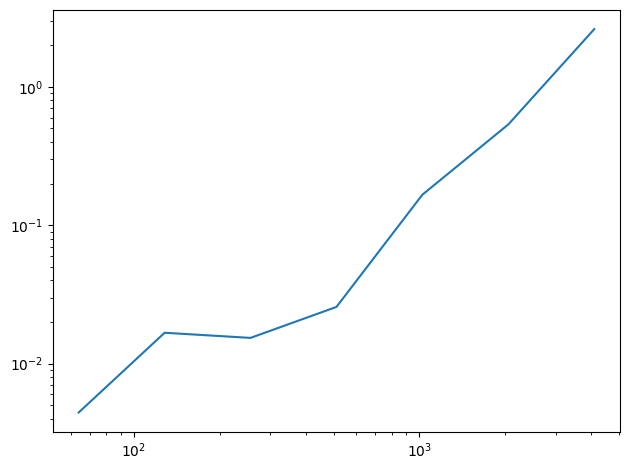

In [4]:
ns = 2 ** np.arange(6, 13)
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Однако, наклон получился близок не к 3, а к 2. Вероятно, это произошло из-за того, что в данном случае производительность np.linalg.solve близка к квадратичной.

Напишем функцию для analyze2:

In [5]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Результаты для analyze2:

64
135 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
593 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
2.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
17.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
65.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
344 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
875 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1783632755611086

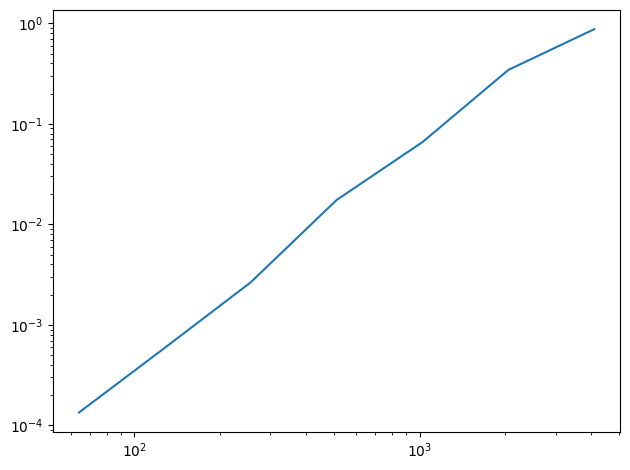

In [6]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

В итоге получили почти прямую линию с наклоном, близким к 2, как и ожидалось.

Результаты тестирования scipy.fftpack.dct

64
36 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
43.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
39.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
512
43.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
1024
53.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
2048
64.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
4096
117 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


0.23861880631336774

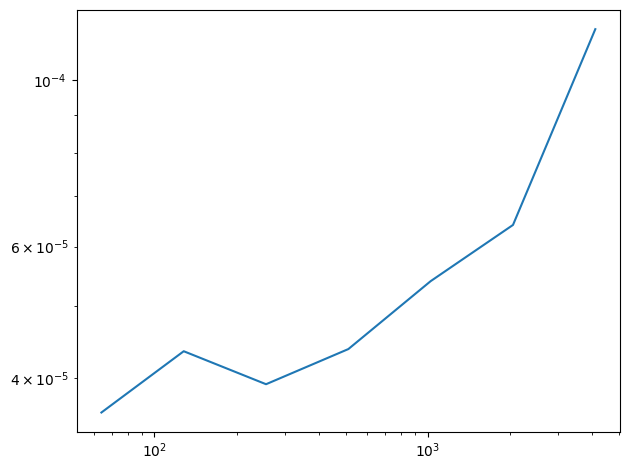

In [7]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)
    
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

По графику можно увидеть, что эта функция работает быстрее, время её работы пропорционально N * log(N).

Теперь проанализируем dct_iv

In [8]:
def dct_iv(ys, freqs, ts):
  N = len(ys)
  ts = (0.5 + np.arange(N))/N
  fs = (0.5 + np.arange(N))/2
  args = np.outer(ts,fs)
  M = np.cos(PI2*args)
  amps = np.dot(M, ys) / 2
  return amps

64
184 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
1.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
2.13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
14.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
42.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
180 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
1.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.036167720281371

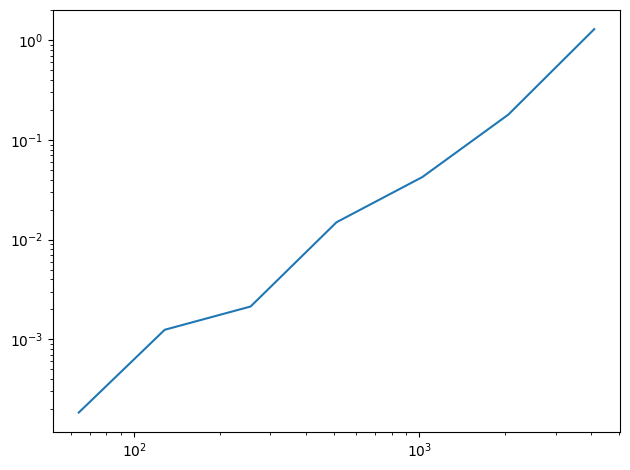

In [9]:
best4 = run_speed_test(ns, dct_iv)
plot_bests(ns, best4)

В итоге получили искривлённую линию с наклоном около 1.9.

# Упражнение 6.2


Oдно из основных применений ДКП - это сжатие звука и изображений.
В простейшей форме ДКП при сжатии работает следующим
образом:
1. Разбивает длинный сигнал на сегменты.
2. Вьчисляет ДКП каждого сегмента.
3. Определяет частотные компоненты с такой амплитудой, что
их не слышно, и удаляет их, сохраняя только оставшиеся частоты
и амплитуды.
4. При воспроизведении сигнала загружает частоты и амплитуды
каждого сегмента и применяет обратное ДКП.

Реализуйте версию этого алгоритма и примените его для записи
музыки или речи. Сколько компонент можно удалить до того, как
разница станет заметной?

Для того, чтобы этот метод стал практичным, нужен способ хранения прореженного массива, то есть массива, где большинство элементов равно нулю. NumPy (SciPy)дает несколько способов работы с прореженными массивами; о них можно прочитать на веб-странице http://docs.scipy.org/doc/scipy/reference/sparse.html

Загрузим саму запись и послушаем:

In [11]:
from thinkdsp import read_wave

wave = read_wave('piano.wav')
wave.make_audio()

Извлечем из неё сегмент.

In [12]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сигнала.

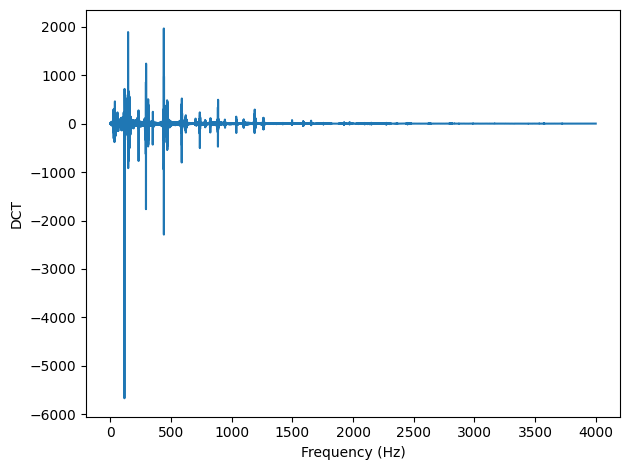

In [13]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Создадим функцию, которая убирает из ДКП частоты со значениями ниже заданного treshold.

In [14]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим эту функцию к заданному сигналу.

17751	22050	80.50340136054422


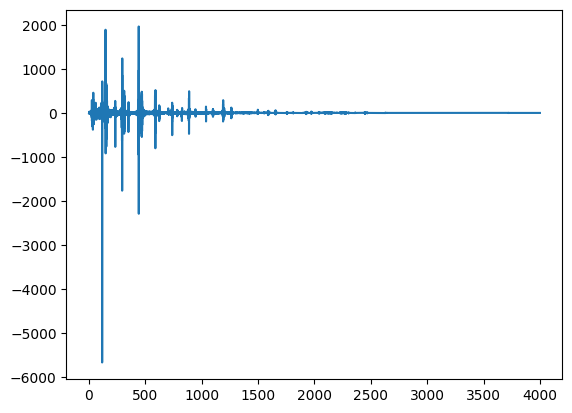

In [15]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=1)
seg_dct.plot(high=4000)

In [16]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Звук остался практически неизменным при сжатии в 85%.

Создадим функцию, которая позволит получить спектрограмму ДКП:

In [18]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Теперь можно сжать все сегменты ДСП.

In [19]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.002)

1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1020	1024	99.609375
1017	1024	99.31640625
1012	1024	98.828125
1012	1024	98.828125
1017	1024	99.31640625
1012	1024	98.828125
1011	1024	98.73046875
245	1024	23.92578125
166	1024	16.2109375
155	1024	15.13671875
143	1024	13.96484375
158	1024	15.4296875
140	1024	13.671875
151	1024	14.74609375
145	1024	14.16015625
154	1024	15.0390625
144	1024	14.0625
140	1024	13.671875
146	1024	14.2578125
152	1024	14.84375
147	1024	14.35546875
150	1024	14.6484375
151	1024	14.74609375
148	1024	14.453125
145	1024	14.16015625
135	1024	13.18359375
145	1024	14.16015625
148	1024	14.453125
157	1024	15.33203125
161	1024	15.72265625
150	1024	14.6484375
152	1024	14.84375
139	1024	13.57421875
144	1024	14.0625
147	1024	14.35546875
141	1024	13.76953125
176	1024	17.1875
151	1024	14.74609375
146	1024	14.2578125
154	1024	15.0390625
158	1024	15.4296875
146	1024	14.2578125
155	1024	15.13671875
142	1024	13.8671875
136	1024	13.28125
150	1024	14.6484

In [20]:
wave2 = spectro.make_wave()
wave2.make_audio()

Если увеличить сжатие, то становятся заметны шумы.

In [21]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.008)

1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1024	1024	100.0
1022	1024	99.8046875
1022	1024	99.8046875
1022	1024	99.8046875
1022	1024	99.8046875
1022	1024	99.8046875
1022	1024	99.8046875
661	1024	64.55078125
378	1024	36.9140625
320	1024	31.25
290	1024	28.3203125
295	1024	28.80859375
276	1024	26.953125
271	1024	26.46484375
274	1024	26.7578125
303	1024	29.58984375
294	1024	28.7109375
281	1024	27.44140625
299	1024	29.19921875
299	1024	29.19921875
285	1024	27.83203125
300	1024	29.296875
290	1024	28.3203125
288	1024	28.125
287	1024	28.02734375
270	1024	26.3671875
312	1024	30.46875
320	1024	31.25
305	1024	29.78515625
307	1024	29.98046875
298	1024	29.1015625
306	1024	29.8828125
290	1024	28.3203125
288	1024	28.125
291	1024	28.41796875
284	1024	27.734375
368	1024	35.9375
310	1024	30.2734375
276	1024	26.953125
305	1024	29.78515625
299	1024	29.19921875
282	1024	27.5390625
296	1024	28.90625
287	1024	28.02734375
295	1024	28.80859375
302	1024	29.4921875
296	1024	28

In [22]:
wave2 = spectro.make_wave()
wave2.make_audio()

# Упражнение 6.3
В репозитории этой книги есть блокнот Jupyter под названием phase.ipnyb, в котором исследуется влияние фазы на восприятие звука. Прочтите этот блокнот и «погоняйте» примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

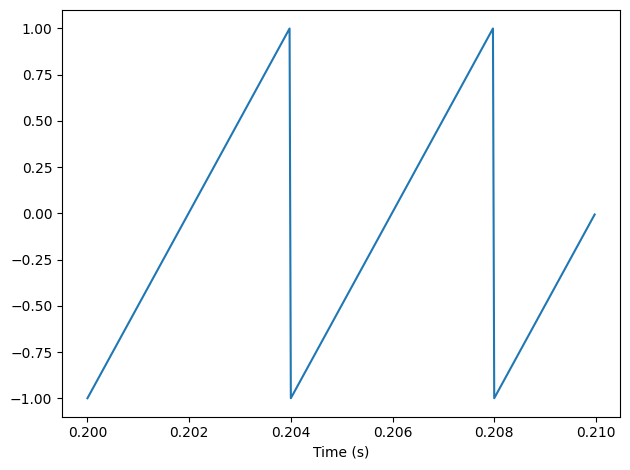

In [24]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=250, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.segment(start=0.2,duration=0.01).plot()
decorate(xlabel='Time (s)')
wave.make_audio()

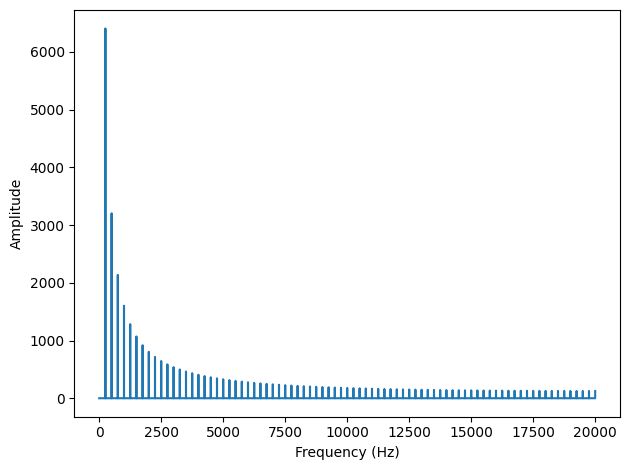

In [25]:

spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

In [26]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

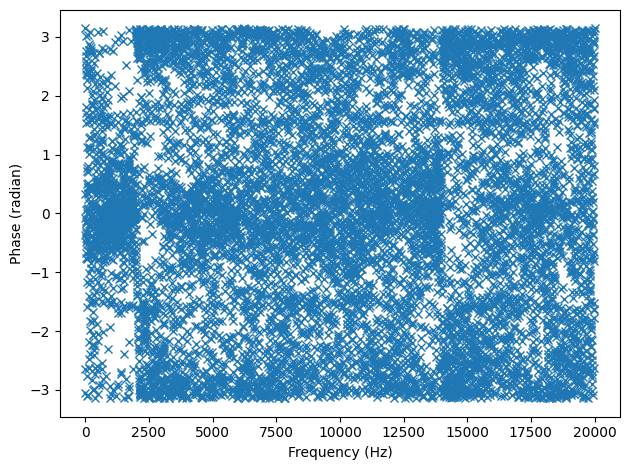

In [27]:
plot_angle(spectrum, thresh=0)

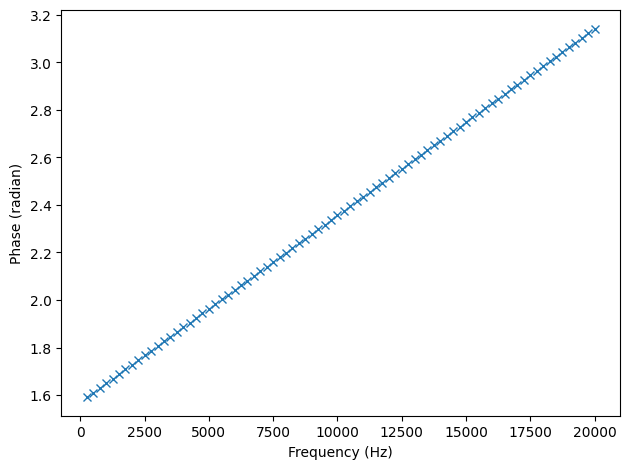

In [29]:
plot_angle(spectrum, thresh=1)

In [31]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.

    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

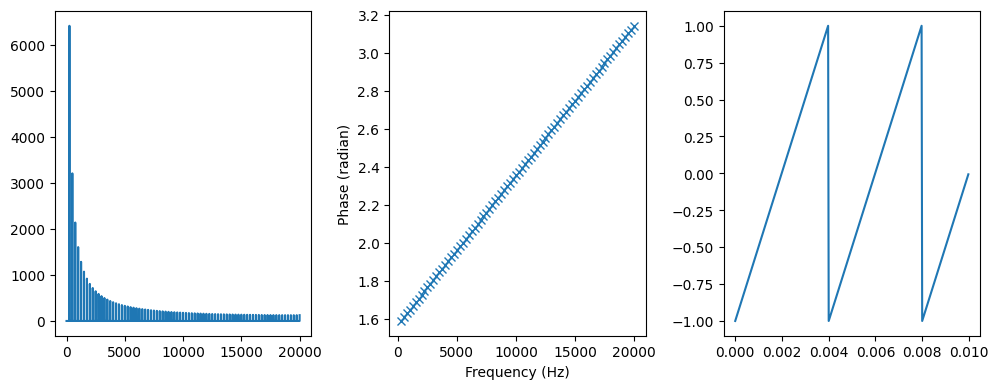

In [32]:
plot_three(spectrum)

Теперь меняем сигнал:

In [34]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

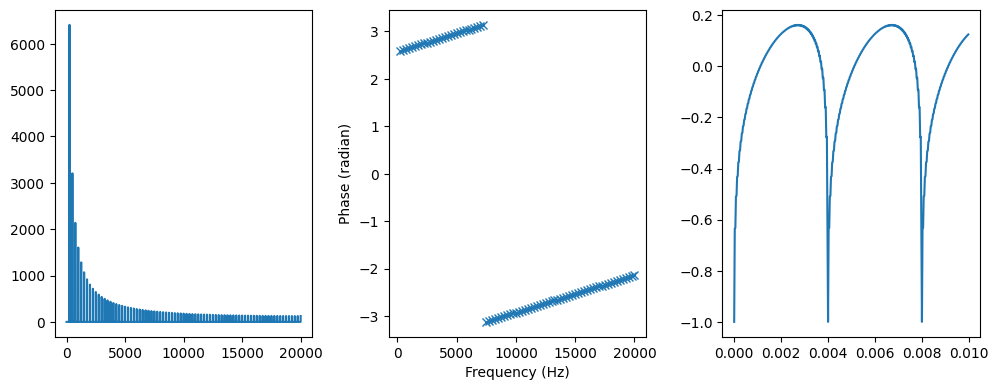

In [35]:
spectrum2 = rotate_angle(spectrum, 1)
plot_three(spectrum2)

In [36]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

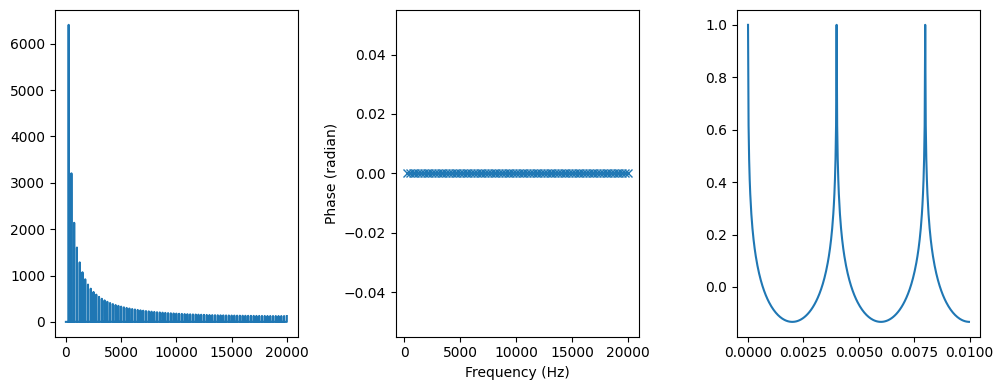

In [37]:
spectrum3 = zero_angle(spectrum2)
plot_three(spectrum3)

Сигнал не меняется.


In [38]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

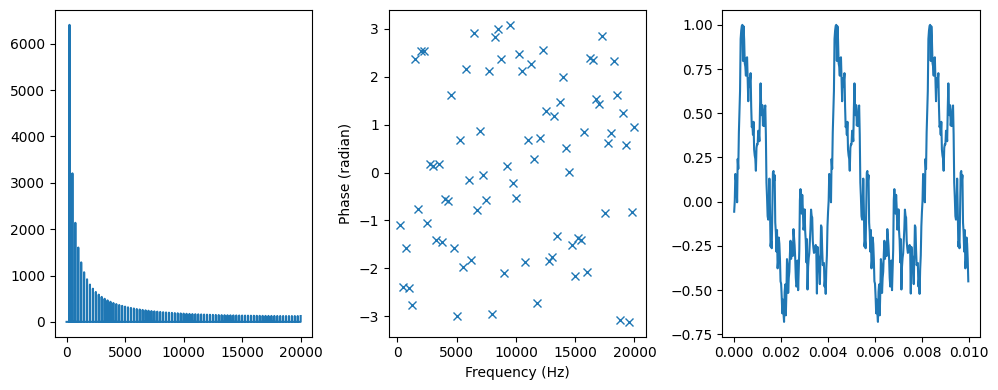

In [39]:
spectrum4 = random_angle(spectrum2)
plot_three(spectrum4)

Звук стал более "электронным".

Для звуков с простой гармонической структурой мы не слышим измнения в фазовой структуре, при условии что гармоническая структура неизменна.